# Imports

In [1]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import pyreadr

from sklearn.calibration import CalibratedClassifierCV

# Preprocessing

In [2]:
def load_csv(dataset, outcome):
        outcome = pd.read_csv(outcome, sep='\t', index_col=0)        
            
        df = pd.read_csv(dataset, sep='\t', index_col=0)
        data_merged = df.merge(outcome, on="Samples")

        data = data_merged.iloc[:,:-2]
        target = data_merged.iloc[:,-1:]

        data, eval_data, target, eval_target = train_test_split(data,target,test_size=.20)

        return data, target, eval_data, eval_target

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelBinarizer

def correct_dtypes(target):
    target=target.astype('category')
    target=target.map({'Basal-like':0,'HER2-enriched':1, 'Luminal A':2, 'Luminal B':3})

    return target

In [4]:
def load_data(dataset, subtypes):    

    subtypes = pd.read_csv(subtypes, sep='\t', index_col=0)        

    df = pd.read_csv(dataset, sep='\t')
    df = df.transpose()

    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header

    data = pd.concat([df, subtypes], axis=1, join="inner")

    data.columns = data.columns.str.strip()

    target = data['PAM50']
    target = correct_dtypes(target)

    data = data.drop(columns=['PAM50'])
    data = data.astype('float')

    x, eval_data, y, eval_target = train_test_split(data, target, test_size=0.2, train_size=0.8)
    train_data, val_data, train_target, val_target = train_test_split(x, y, test_size = 0.25,train_size =0.75)

    return train_data, val_data, eval_data, train_target, val_target, eval_target

In [5]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
        ))

In [6]:
transformer = Pipeline([
            ('features', FeatureUnion(n_jobs=1, transformer_list=[
                # Part 1
                ('boolean', Pipeline([
                    ('selector', TypeSelector('bool')),
                ])),  # booleans close
                
                ('numericals', Pipeline([
                    ('selector', TypeSelector(np.number)),
                    ('imputer',SimpleImputer()),
                    ('scaler', StandardScaler()),
                    
                ])),  # numericals close
                
                # Part 2
                ('categoricals', Pipeline([
                    ('selector', TypeSelector('category')),
                    ('labeler', StringIndexer()),
                    ('encoder', OneHotEncoder()),
                ]))  # categoricals close
            ])),  # features close
])  # pipeline close

estimators=[
            ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
            ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
            #('ridge',CalibratedClassifierCV(RidgeClassifier())),
            ('elasticnet',SGDClassifier(loss='log_loss', penalty='elasticnet')),
            ('random_forest',RandomForestClassifier(n_estimators=100, random_state=0)),
            #('svc', CalibratedClassifierCV(LinearSVC(dual=True, C=10))),
            ('deep_nn',MLPClassifier()),
            #('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto'))
]

_metrics={'f1':make_scorer(f1_score),'auc':make_scorer(roc_auc_score),
         'accuracy':'accuracy','logloss':make_scorer(log_loss)}

estimator_names=[model[0] for model in estimators]

In [7]:
import time

# cols_results=['model', 'train_runtime', 'prediction_runtime', 'accuracy']

def train_model(data, target):
    pipes={}

    for model in estimators:
        pipe=Pipeline(steps=[('data_prep', transformer),model])
        pipe.fit(data,target.values.ravel())
        pipes[pipe.steps[1][0]]=pipe

    return pipes

In [18]:
def prediction_results(pipes, val_data):

    pred=pd.DataFrame()
    pred_proba={}
    
    for name,pipe in pipes.items():

        pred[name]=pipe.predict(val_data)
        pred_proba[name]=pipe.predict_proba(val_data)
        
    return pred, pred_proba

In [9]:
# Example tsv files
datasets = {
            'cnv': 'data/breast/CNV_processedDat.txt',
            'mrna': 'data/breast/mRNA_processedDat.txt',
            'prot': 'data/breast/PROT_processedDat.txt'
}
        
labels = 'data/breast/TCGA_BRCA_subtypes.txt'

In [20]:
import time

pipe_list = {}
pred = {}
pred_proba = {}

train_data = {}
train_target = {}

val_data = {}
val_target = {}

eval_data = {}
eval_target = {}

for modality in datasets:
    train_data[modality], val_data[modality], eval_data[modality], train_target[modality], val_target[modality], eval_target[modality] = load_data(datasets[modality], labels)
    print('dataset: ' + modality)

    pipe_list[modality] = train_model(train_data[modality], train_target[modality])

    pred[modality], pred_proba[modality] = prediction_results(pipe_list[modality], val_data[modality])
    

dataset: cnv


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


dataset: mrna
dataset: prot


## Initial Model Scoring

In [21]:
col_names = ['model', 'f1', 'accuracy']
results_list = {}

for modality in datasets:
    results = pd.DataFrame(columns=col_names)

    for name, pipe in pipe_list[modality].items():
        #print(roc_auc_score(val_target[modality], pred_proba[modality][name], average='weighted', multi_class='ovr'))
        #results = pd.concat([results, pd.DataFrame([[name, roc_auc_score(val_target[modality], pred_proba[modality][name], average='weighted', multi_class='ovr'), f1_score(val_target[modality], pred[modality][name], average='weighted'), accuracy_score(val_target[modality], pred[modality][name])]], columns=col_names)], ignore_index=True)
        results = pd.concat([results, pd.DataFrame([[name, f1_score(val_target[modality], pred[modality][name], average='weighted'), accuracy_score(val_target[modality], pred[modality][name])]], columns=col_names)], ignore_index=True)

    results_list[modality] = results

### CNV

In [22]:
results_list['cnv']

,model,f1,accuracy
0,logistic,0.609871,0.63
1,lasso,0.636713,0.65
2,elasticnet,0.531122,0.54
3,random_forest,0.566250,0.60
4,deep_nn,0.571747,0.58


<AxesSubplot: >

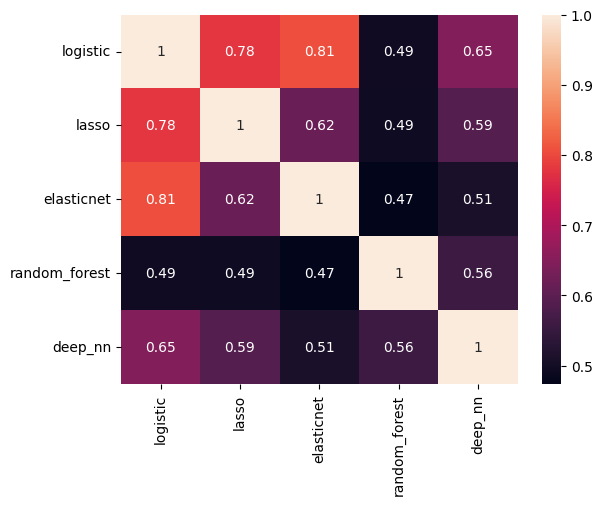

In [23]:
sns.heatmap(pred['cnv'].corr(), annot=True)

### mRNA

In [24]:
results_list['mrna']

,model,f1,accuracy
0,logistic,0.829851,0.82
1,lasso,0.930165,0.93
2,elasticnet,0.852365,0.85
3,random_forest,0.879115,0.88
4,deep_nn,0.861508,0.86


<AxesSubplot: >

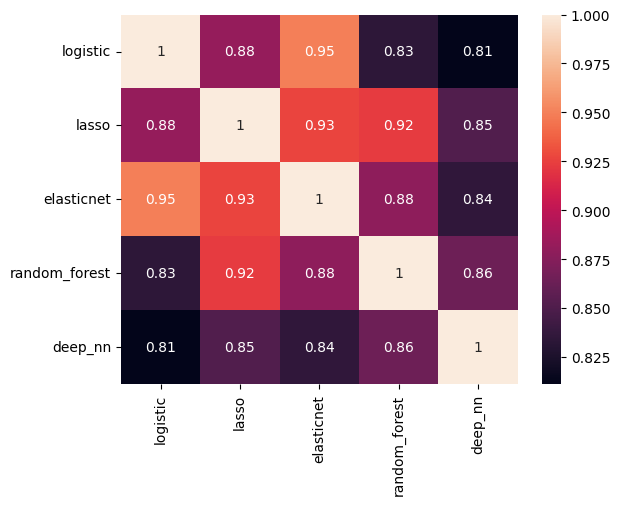

In [25]:
sns.heatmap(pred['mrna'].corr(), annot=True)

### Prot

In [26]:
results_list['prot']

,model,f1,accuracy
0,logistic,0.588412,0.571429
1,lasso,0.467120,0.523810
2,elasticnet,0.630798,0.619048
3,random_forest,0.673882,0.666667
4,deep_nn,0.334845,0.428571


<AxesSubplot: >

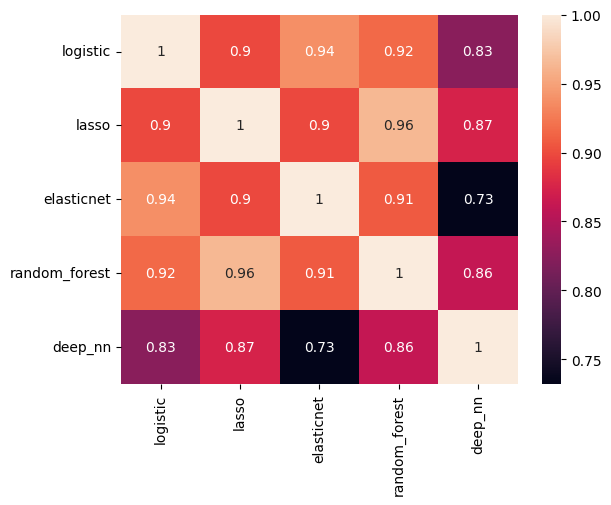

In [27]:
sns.heatmap(pred['prot'].corr(), annot=True)

### Plotting score

In [28]:
def score_estimators(pipes, data, target, estimators=estimator_names,n_splits=5,metrics=['f1','auc','accuracy','logloss']):
    metrics={key : _metrics[key] for key in metrics}
    scorers=[]
    labels=[]
    
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe=pipes[pipe_name]
            labels.append(pipe_name)
            kf=KFold(n_splits)
            model_score=cross_validate(pipe,data,target,scoring=metrics,cv=kf)
            scorers.append(model_score)
             
    score_lists={}

    for metric in metrics:
        score_lists[metric]=[score['test_'+metric] for score in scorers]
        
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)

In [29]:
def perf(pipes, eval_data, eval_target, results, cols_results):
    for pipe_name in pipes.keys():
        time_start = time.time()

        pipe=pipes[pipe_name]
        predictions = pipe.predict(eval_data)

        time_run = time.time()-time_start

        results = pd.concat([results, pd.DataFrame([[pipe_name,accuracy_score(eval_target,predictions),time_run]],columns=cols_results)],ignore_index=True)

    return results

In [30]:
cols_results=['model', 'accuracy', 'prediction_runtime']
results = pd.DataFrame(columns=cols_results)

for modality in pipe_list:
    results = perf(pipe_list[modality], eval_data[modality], eval_target[modality].values.ravel(), results, cols_results)
    results


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- A1CF
- A3GALT2
- A4GALT
- A4GNT
- AADAC
- ...
Feature names seen at fit time, yet now missing:
- ACP1
- ADCK5
- AGRN
- AKAP17A
- ANKLE2
- ...


In [ ]:
results

,model,accuracy,prediction_runtime
0,logistic,0.476190,0.205347
1,lasso,0.666667,0.131914
2,ridge,0.666667,0.122875
3,elasticnet,0.476190,0.153523
4,random_forest,0.619048,0.182565
5,svc,0.666667,0.116040
6,deep_nn,0.523810,0.132174
7,logistic,0.476190,0.130194
8,lasso,0.666667,0.111920
9,ridge,0.666667,0.101862


## Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

def tune_param(model,pipes,param_grid,refit='accuracy',chart=None,data=data,target=target,cv=5):
    
    param_grid={model+'__'+key : param_grid[key] for key in param_grid.keys()}

    xgbcv=GridSearchCV(pipes[model],param_grid,scoring=_metrics,refit=refit,cv=cv)
    xgbcv.fit(data,target.values.ravel())

    print('best score: '+str(xgbcv.best_score_))
    print('best params: '+str(xgbcv.best_params_))
    results=pd.DataFrame(xgbcv.cv_results_)
    
    '''if 'line' in chart:
        for i,param in enumerate(param_grid.keys()):
            graph_data=results[['param_'+param,'mean_test_'+refit,'mean_train_'+refit]]
            graph_data=graph_data.rename(columns={'mean_test_'+refit:'test','mean_train_'+refit:'train'})
            graph_data=graph_data.melt('param_'+param, var_name='type',value_name=refit)
            plt.figure(i)
            plot=sns.lineplot(x='param_'+param,y=refit,hue='type',data=graph_data)
            
    if 'heatmap' in chart:
        assert len(param_grid) == 2,  'heatmap only works with 2 params, {} passed'.format(str(len(param_grid)))
        
        param1=list(param_grid.keys())[0]
        param2=list(param_grid.keys())[1]

        graph_data=results[['param_'+param1,'param_'+param2,'mean_test_'+refit]]
        graph_data=graph_data.pivot(index='param_'+param1,columns='param_'+param2,values='mean_test_'+refit)
        sns.heatmap(graph_data,annot=True,xticklabels=True,yticklabels=True).set(xlabel=param2,ylabel=param1)'''

### Random Forest

In [ ]:
pipe_list['mrna']['random_forest'].named_steps['random_forest'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [ ]:
param_grid={'max_depth':[3,8,13,18]}
tune_param('random_forest', pipe_list['mrna'], param_grid,chart='line')

param_grid={'max_leaf_nodes':[5,10,15,20,25]}
tune_param('random_forest',pipe_list['mrna'], param_grid,chart='line')

param_grid={'n_estimators':[10,50,100,150,200,500]}
tune_param('random_forest', pipe_list['mrna'], param_grid,chart='line')



/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "

best score: nan
best params: {'random_forest__max_depth': 3}


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "

best score: nan
best params: {'random_forest__max_leaf_nodes': 5}


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 107, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "

best score: nan
best params: {'random_forest__n_estimators': 10}


In [ ]:
pipe_list[0]['random_forest'].set_params(**{'random_forest__max_depth': 8})
pipe_list[0]['random_forest'].set_params(**{'random_forest__max_leaf_nodes': 25})
pipe_list[0]['random_forest'].set_params(**{'random_forest__max_leaf_nodes': 200})

Pipeline(steps=[('data_prep',
                 Pipeline(steps=[('features',
                                  FeatureUnion(n_jobs=1,
                                               transformer_list=[('boolean',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='bool'))])),
                                                                 ('numericals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype=<class 'numpy.number'>)),
                                                                                  ('imputer',
                                                                                   SimpleImputer()),
                                                                                  ('scaler',
                                                                                   StandardScaler())])),
                                                                 ('categoricals',
                                                                  Pipeline(steps=[('selector',
                                                                                   TypeSelector(dtype='category')),
                                                                                  ('labeler',
                                                                                   StringIndexer()),
                                                                                  ('encoder',
                                                                                   OneHotEncoder())]))]))])),
                ('random_forest',
                 RandomForestClassifier(max_depth=8, max_leaf_nodes=200))])

## Ensemble

### Learning Curves

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

KeyboardInterrupt: 

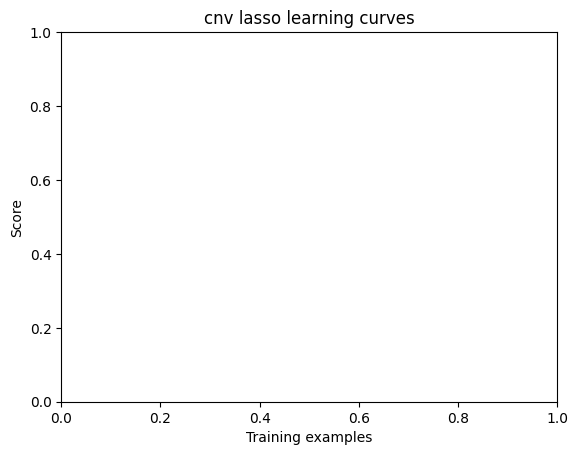

In [ ]:
to_plot=['random_forest','lasso','ridge']

for modality in datasets:
    t=transformer
    t.fit(train_data[modality])
    t=t.transform(train_data[modality])
    for name in pipe_list[modality].keys():
        if name in to_plot:
            g=plot_learning_curve(pipe_list[modality][name].named_steps[name],modality + ' ' + name+' learning curves',t,train_target[modality].values.ravel(),cv=KFold(4),n_jobs=4)

### Weight Optimization

In [31]:
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution

# normalize a vector to have unit norm
def normalize(weights):
 # calculate l1 vector norm
 result = norm(weights, 1)
 # check for a vector of all zeros
 if result == 0.0:
    return weights
 # return normalized vector (unit norm)
 return weights / result

# make an ensemble prediction for multi-class classification
def ensemble_predictions(modality, members, weights):
 # make predictions
 yhats = [pred_proba[modality][model] for model in members]
 yhats = array(yhats)
 # weighted sum across ensemble members
 summed = tensordot(yhats, weights, axes=((0),(0)))
 # argmax across classes
 result = argmax(summed, axis=1)
 return result
 
# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(modality, members, weights, testX, testy):
 # make prediction
 yhat = ensemble_predictions(modality, members, weights)
 # calculate accuracy
 return accuracy_score(testy, yhat)

# loss function for optimization process, designed to be minimized
def loss_function(weights, modality, members, testX, testy):
 # normalize weights
 normalized = normalize(weights)
 # calculate error rate
 return 1.0 - evaluate_ensemble(modality, members, normalized, testX, testy)


In [32]:
def find_weights(modality, estimators):
    n_members = len(estimators)
    # evaluate averaging ensemble (equal weights)
    weights = [1.0/n_members for _ in range(n_members)]
    # define bounds on each weight
    bound_w = [(0.0, 1.0)  for _ in range(n_members)]
    # arguments to the loss function
    search_arg = (modality, pipe_list[modality], val_data[modality], val_target[modality],)
    # global optimization of ensemble weights
    result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)
    # get the chosen weights
    weights = normalize(result['x'])

    return weights

In [33]:
weights = {}

for modality in datasets:
    weights[modality] = find_weights(modality, estimators)

In [34]:
weights

{'cnv': array([0.15040642, 0.23289916, 0.00649553, 0.53446704, 0.07573185]),
 'mrna': array([0.28869939, 0.43336851, 0.0285402 , 0.23334682, 0.01604507]),
 'prot': array([0.26525749, 0.06422321, 0.26443131, 0.3634337 , 0.0426543 ])}

### Combining Modality Models:

Equal Weights:

In [36]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

vote_equal = {}
col_names=['modality', 'f1', 'accuracy']
vote_equal_metrics = pd.DataFrame(columns=col_names)

for modality, df in datasets.items():
    estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipe_list[modality].values()] 

    # Same weights for each model
    vote_equal[modality]=Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = 'soft'))])

    vote_equal[modality].fit(train_data[modality], train_target[modality].values.ravel())

    predictions=vote_equal[modality].predict(eval_data[modality])

    vote_equal_metrics = pd.concat([vote_equal_metrics, pd.DataFrame([[modality, f1_score(eval_target[modality], predictions, average='weighted'), accuracy_score(eval_target[modality], predictions)]], columns=col_names)], ignore_index=True)

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


In [37]:
vote_equal_metrics

,modality,f1,accuracy
0,cnv,0.603082,0.613861
1,mrna,0.767788,0.770000
2,prot,0.410582,0.428571


Optimized Weights (Differential Evolution)

In [38]:
vote_weighted = {}
vote_weighted_metrics = pd.DataFrame(columns=col_names)

for modality, df in datasets.items():
    estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipe_list[modality].values()] 
    
    # Optimized weights (differential evolution)
    vote_weighted[modality]=Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = 'soft', weights=weights[modality]))])
    vote_weighted[modality].fit(train_data[modality],train_target[modality].values.ravel())
    predictions=vote_weighted[modality].predict(eval_data[modality])

    vote_weighted_metrics = pd.concat([vote_weighted_metrics, pd.DataFrame([[modality, f1_score(eval_target[modality], predictions, average='weighted'), accuracy_score(eval_target[modality], predictions)]], columns=col_names)], ignore_index=True)

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


In [39]:
vote_weighted_metrics

,modality,f1,accuracy
0,cnv,0.622276,0.643564
1,mrna,0.827874,0.830000
2,prot,0.358730,0.380952


### Feature Selection Using SequencialFeatureSelector

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

sfs1 = sfs(vote['mrna'], k_features=4, forward=False, verbose=1, scoring='neg_mean_squared_error')

sfs1 = sfs1.fit(data['mrna'], target['mrna'])

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 402, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 360, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 446, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 1193, in fit_transform
    results = self._parallel_func(X, y, fit_params, _fit_transform_one)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 1215, in _parallel_func
    return Parallel(n_jobs=self.n_jobs)(
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/_parallel_backends.py", line 597, in __init__
    self.results = batch()
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 288, in __call__
    return [func(*args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/joblib/parallel.py", line 288, in <listcomp>
    return [func(*args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 894, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 446, in fit_transform
    return last_step.fit_transform(Xt, y, **fit_params_last_step)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/base.py", line 851, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/utils/_set_output.py", line 142, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/var/folders/bl/4vcbfl1n40sbx41l9qnkmm3h0000gn/T/ipykernel_13502/1010120027.py", line 7, in transform
    assert isinstance(X, pd.DataFrame)
AssertionError


### Feature Selection Using RFECV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(5)
min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(
    estimator=vote['cnv'],
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)

rfecv.fit(data['cnv'], target['cnv'])

# Plot pixel ranking
#plt.matshow(ranking, cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Ranking of pixels with RFE")
plt.show()

AssertionError: 

### Testing Model Combinations

In [42]:
from itertools import combinations

def combine_models(final_estimators, pipes, data, target, eval_data, eval_target):

    combos=[]
    for L in range(2, len(final_estimators)+1):
        for subset in combinations(final_estimators, L):
            combos.append(list(subset))

    combo_names=[]
    auc=[]
    f1=[]
    logloss=[]
    accuracy=[]

    for combo in combos:
        estimators=[(name,clone(pipes[name].named_steps[name])) for name in combo] 
        vote=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators))])
        vote.fit(data,target)
        predictions=vote.predict(eval_data)

        #auc.append(roc_auc_score(eval_target,predictions))
        accuracy.append(accuracy_score(eval_target,predictions))
        #logloss.append(log_loss(eval_target,predictions))
        f1.append(f1_score(eval_target,predictions, average='weighted'))
        combo_names.append(str(list(combo)))
        
    score=pd.DataFrame()
    score['combo']=combo_names
    #score['auc']=auc
    score['f1']=f1
    score['accuracy']=accuracy

    return score

**CNV**

In [45]:
score_cnv = combine_models(['logistic', 'lasso', 'random_forest', 'deep_nn'], pipe_list['cnv'], train_data['cnv'], train_target['cnv'],  eval_data['cnv'], eval_target['cnv'] )



In [47]:
print(score_cnv)

None


In [ ]:
combine_models(['logistic', 'lasso', 'ridge', 'elasticnet','random_forest', 'svc', 'deep_nn'], pipe_list['mrna'], train_data['mrna'], train_target['mrna'],  eval_data['mrna'], eval_target['mrna'] )

### Creating Ensemble Model

In [48]:
# TO DO: Fix this so that we consider validation data (is it the same data split just combined?)
def combine_data(datasets, subtypes):    

    subtypes = pd.read_csv(subtypes, sep='\t', index_col=0)        

    frames = {}
    
    for modality, df in datasets.items():
        frames[modality] = pd.read_csv(df, sep='\t')
        frames[modality] = frames[modality].transpose()
        new_header = frames[modality].iloc[0] #grab the first row for the header
        frames[modality] = frames[modality][1:] #take the data less the header row
        frames[modality].columns = new_header #set the header row as the df header

    df_list = list(frames.values())
    data = pd.concat(frames.values(), axis=1, join="inner")

    data = pd.concat([data, subtypes], axis=1, join="inner")

    target = data['PAM50']
    target = correct_dtypes(target)

    data = data.drop(columns=['PAM50'])
    data = data.astype('float')

    data, eval_data, target, eval_target = train_test_split(data,target,test_size=.20)

    return data, target, eval_data, eval_target

In [ ]:
ensemble_data, ensemble_target, ensemble_eval_data, ensemble_eval_target = combine_data(datasets, labels)

In [ ]:
modality_models=[(model.steps[1][0],clone(model.steps[1][1])) for model in vote_weighted.values()] 

# TO DO: CALCULATION OF WEIGHTS 
ensemble=Pipeline(steps=[('data_prep',transformer),('voter',VotingClassifier(estimators=modality_models, voting = 'soft'))])
ensemble.fit(ensemble_data, ensemble_target.values.ravel())
predictions=ensemble.predict(ensemble_eval_data)

In [ ]:
metrics = pd.DataFrame([[f1_score(ensemble_eval_target, predictions, average='weighted'), accuracy_score(ensemble_eval_target, predictions)]], columns=['f1', 'accuracy'])

metrics

,f1,accuracy
0,0.777242,0.761905


### Saving Model

In [ ]:
from datetime import date
import pickle

today = date.today()

filename = date.today().strftime('%Y_%m_%d') + '_ensemble.sav'
pickle.dump(ensemble, open(filename, 'wb'))

# Comparing Models

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(ensemble_eval_data, ensemble_eval_target)
print(result)

0.9047619047619048
